# ENTRENAR MODELO CON TENSORFLOW 🙂

In [1]:
# Instalar dependencias necesarias
!pip install tensorflow
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


**Descargar el dataset desde Roboflow**

In [ ]:
# Verifico si la GPU esta disponible
import tensorflow as tf
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))


In [ ]:
%mkdir /content/dataset
%cd /content/dataset

In [2]:
from roboflow import Roboflow

# Reemplaza con tu API Key de Roboflow
roboflow_api_key = "bcLW8UrIUgjaKEwd8Yym"

# Inicializa Roboflow y descarga el dataset
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace().project("oranges-detection")  # Reemplaza con el nombre de tu proyecto
dataset = project.version(1).download("tfrecord")        # Descarga en formato TensorFlow TFRecord


loading Roboflow workspace...
loading Roboflow project...
Exporting format tfrecord in progress : 85.0%
Version export complete for tfrecord format



Extracting Dataset Version Zip to oranges-detection-1 in tfrecord:: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


#

**Carga dataset**

In [21]:
import tensorflow as tf
import os

# Verifica si la ruta al archivo TFRecord es correcta
print(os.path.exists("/content/oranges-detection-1/train/orange.tfrecord"))  # Imprime True si el archivo existe, False en caso contrario

# Ruta a los archivos TFRecord descargados
train_tfrecord_path = "/content/oranges-detection-1/train/orange.tfrecord"  # Ajusta con el nombre del archivo descargado
test_tfrecord_path = "/content/oranges-detection-1/test/orange.tfrecord"

# Tamaño de las imágenes (definido por el dataset de Roboflow)
IMG_SIZE = 640
BATCH_SIZE = 32

# Definir la función para parsear los TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
        "image/object/class/label": tf.io.VarLenFeature(tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "image/width": tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(parsed_example["image/encoded"])
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.sparse.to_dense(parsed_example["image/object/class/label"], default_value=0)

    # Check if label is empty and assign a default value if necessary
    label = tf.cond(tf.equal(tf.size(label), 0), lambda: tf.constant([0], dtype=tf.int64), lambda: label)

    return image, label[0]  # Seleccionamos el primer label si hay varios

# Crear el dataset de entrenamiento y prueba
train_dataset = tf.data.TFRecordDataset(train_tfrecord_path)
train_dataset = train_dataset.map(parse_tfrecord_fn).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.TFRecordDataset(test_tfrecord_path)
test_dataset = test_dataset.map(parse_tfrecord_fn).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


True


**Visualizar las imagenes (uno por etiqueta)**

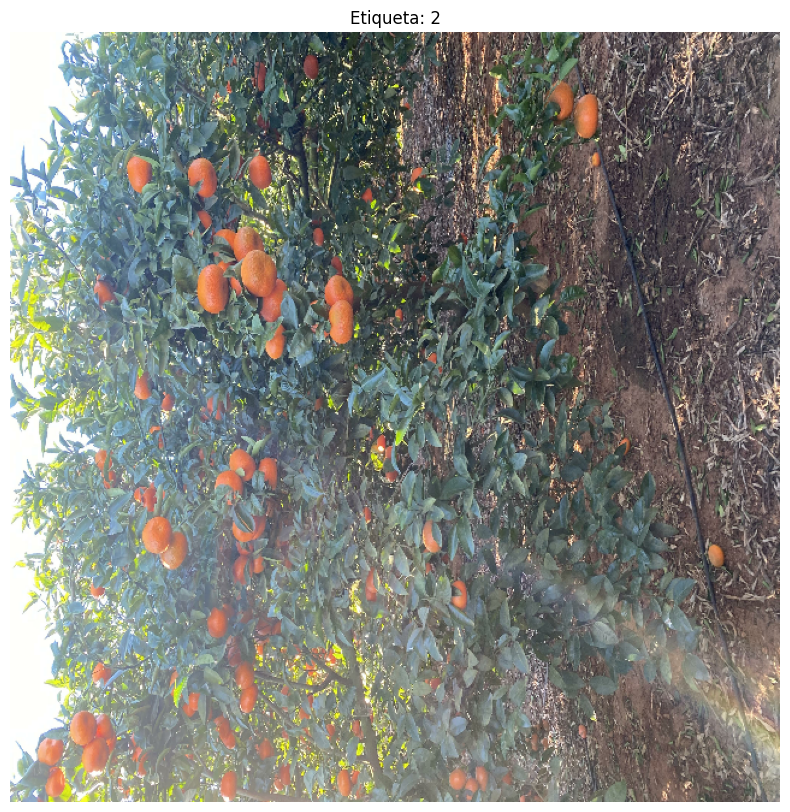

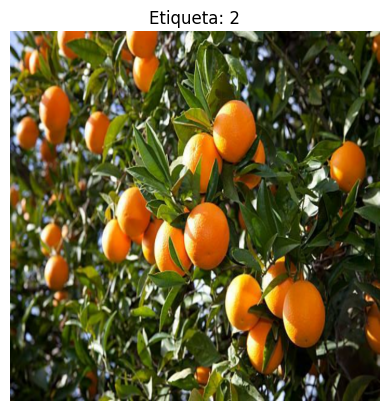

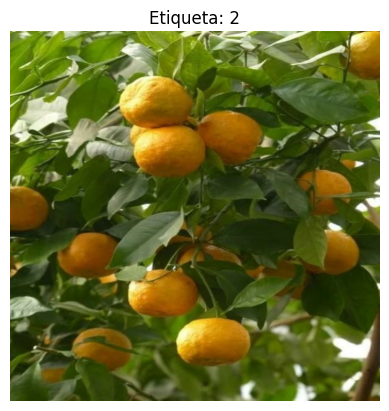

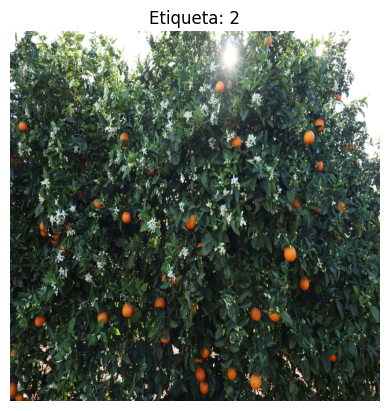

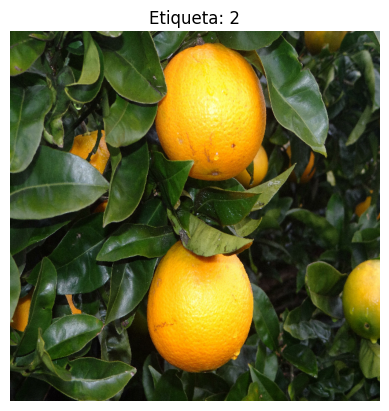

In [35]:
import matplotlib.pyplot as plt

# Mostrar algunas imágenes con sus etiquetas

for images, labels in train_dataset.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy())
        plt.title(f"Etiqueta: {labels[i].numpy()}")
        plt.axis("off")
        plt.show()


**Definir y entrenar el modelo**

In [24]:
# Descargar un modelo base preentrenado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,                # Excluir la capa de clasificación
    weights="imagenet"                # Usar pesos preentrenados de ImageNet
)

# Congelar las capas base
base_model.trainable = False

# Get the number of classes from your project (replace 'your_class_attribute' with the correct attribute name)
num_classes = len(project.classes) # Assuming project has an attribute called 'classes' which is a list of classes


# Construir el modelo completo
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Reduce dimensiones espaciales
    tf.keras.layers.Dense(128, activation='relu'),  # Capa oculta
    tf.keras.layers.Dropout(0.5),  # Regularización
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Número de clases
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Entrenar el modelo
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
     36/Unknown 318s 8s/step - accuracy: 0.6755 - loss: 0.9139

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


36/36 ━━━━━━━━━━━━━━━━━━━━ 360s 9s/step - accuracy: 0.6779 - loss: 0.9074 - val_accuracy: 0.8824 - val_loss: 0.3823
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 339s 9s/step - accuracy: 0.8455 - loss: 0.4695 - val_accuracy: 0.8758 - val_loss: 0.3287
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 390s 10s/step - accuracy: 0.8745 - loss: 0.3870 - val_accuracy: 0.9085 - val_loss: 0.2894
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 371s 8s/step - accuracy: 0.8687 - loss: 0.3469 - val_accuracy: 0.9020 - val_loss: 0.3079
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 325s 8s/step - accuracy: 0.8986 - loss: 0.3147 - val_accuracy: 0.9085 - val_loss: 0.2620
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 386s 8s/step - accuracy: 0.9156 - loss: 0.2780 - val_accuracy: 0.9020 - val_loss: 0.3028
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 376s 8s/step - accuracy: 0.9193 - loss: 0.2457 - val_accuracy: 0.9150 - val_loss: 0.2729
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 406s 9s/step - accuracy: 0.9317 - loss: 0.2096 - val_accuracy: 0.9150 - val_loss: 0

### (Optional) Entrenamiento con diferente modelo preentrado

In [ ]:
from tensorflow import EfficientDetD0

base_model = EfficientDetD0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Congelar las capas base
base_model.trainable = False

# Get the number of classes from your project (replace 'your_class_attribute' with the correct attribute name)
num_classes = len(project.classes) # Assuming project has an attribute called 'classes' which is a list of classes


# Construir el modelo completo
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Reduce dimensiones espaciales
    tf.keras.layers.Dense(128, activation='relu'),  # Capa oculta
    tf.keras.layers.Dropout(0.5),  # Regularización
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Número de clases
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Entrenar el modelo
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)

## Evaluacion

**Evaluar el Modelo**

In [27]:
# Evaluar en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Pérdida en prueba: {test_loss}")
print(f"Precisión en prueba: {test_accuracy * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.9135 - loss: 0.2837
Pérdida en prueba: 0.28967416286468506
Precisión en prueba: 91.50%


**Visualizar Métricas de Entrenamiento**

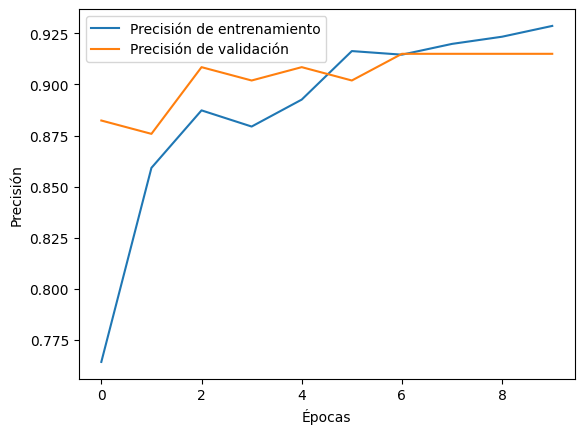

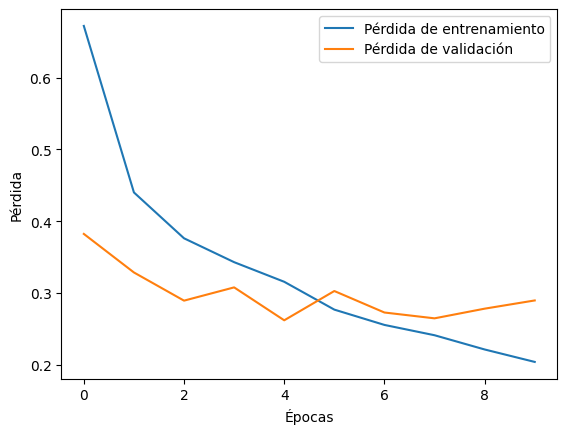

In [25]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


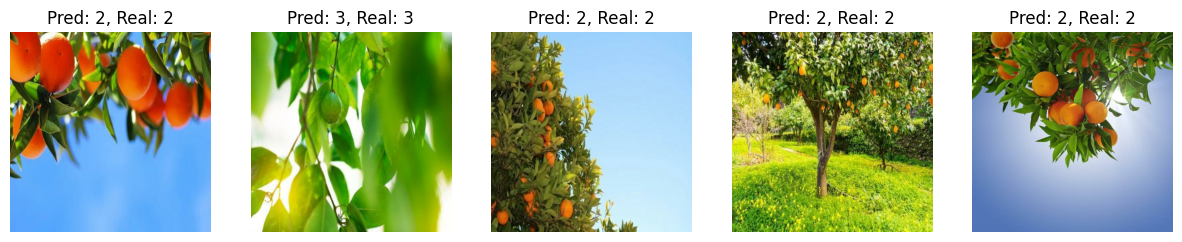

In [26]:
# Realizar predicciones con imágenes de prueba
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Mostrar las primeras 5 imágenes
    plt.figure(figsize=(15, 15))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Pred: {predicted_labels[i].numpy()}, Real: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()


In [34]:
# Exportar modelo guardado
path: str = "/content/models/orange.keras"
model.save(path)

## Opcional (Guardado en Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')